In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

# Added GridSearchCV for hyperparameter tuning and StandardScaler for better scaling

In [2]:
file_path = "..\\data\\stroke_data.csv"
sk = pd.read_csv(file_path)

In [3]:
sk

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
sk.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


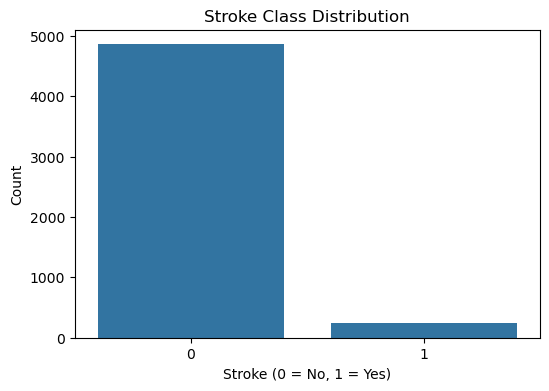

Class distribution (%):
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64


In [6]:
# Visualize stroke class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='stroke', data=sk)
plt.title('Stroke Class Distribution')
plt.xlabel('Stroke (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()
print("Class distribution (%):")
print(sk['stroke'].value_counts(normalize=True) * 100)
# Added to confirm class imbalance (~4.87% stroke cases)

# Stroke Prediction Project

This project aims to predict stroke risk using the `stroke-data.csv` dataset from Kaggle. Due to the rarity of stroke cases, we will address class imbalance and focus on metrics like **Recall** and **ROC-AUC** to ensure high-risk patients are identified. Key steps include:
- Data cleaning and feature selection
- Model training and evaluation
- Emphasis on clinical usefulness

The goal is to create a reliable tool for early stroke risk detection.

In [7]:
sk.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
# Impute missing BMI with median
sk['bmi'] = sk['bmi'].fillna(sk['bmi'].median())
print("Missing values after imputation:")
print(sk.isnull().sum())
# Changed to impute BMI instead of filtering, preserving all 5110 rows

Missing values after imputation:
id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [9]:
sk.stroke.value_counts(normalize = True) * 100

stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

In [10]:
# Create a copy for encoding
encoded_sk = sk.copy()

# Label encode binary variables
le = LabelEncoder()
encoded_sk['gender'] = le.fit_transform(encoded_sk['gender'])  # Male/Female to 0/1
encoded_sk['ever_married'] = le.fit_transform(encoded_sk['ever_married'])  # Yes/No to 0/1
encoded_sk['Residence_type'] = le.fit_transform(encoded_sk['Residence_type'])  # Urban/Rural to 0/1

# One-hot encode multi-category variables
encoded_sk = pd.get_dummies(encoded_sk, columns=['work_type', 'smoking_status'], drop_first=True)

# Drop irrelevant 'id' column
encoded_sk = encoded_sk.drop('id', axis=1)

# Verify encoding
print("Encoded DataFrame Shape:", encoded_sk.shape)
print(encoded_sk.head())
# Added explicit encoding step

Encoded DataFrame Shape: (5110, 16)
   gender   age  hypertension  heart_disease  ever_married  Residence_type  \
0       1  67.0             0              1             1               1   
1       0  61.0             0              0             1               0   
2       1  80.0             0              1             1               0   
3       0  49.0             0              0             1               1   
4       0  79.0             1              0             1               0   

   avg_glucose_level   bmi  stroke  work_type_Never_worked  work_type_Private  \
0             228.69  36.6       1                   False               True   
1             202.21  28.1       1                   False              False   
2             105.92  32.5       1                   False               True   
3             171.23  34.4       1                   False               True   
4             174.12  24.0       1                   False              False   

   work_

In [11]:
# Add interaction terms
encoded_sk['age_hypertension'] = encoded_sk['age'] * encoded_sk['hypertension']
encoded_sk['age_heart_disease'] = encoded_sk['age'] * encoded_sk['heart_disease']
print("DataFrame Shape After Feature Engineering:", encoded_sk.shape)
# Added to capture interactions for better prediction

DataFrame Shape After Feature Engineering: (5110, 18)


In [12]:
encoded_sk.stroke.value_counts(normalize = True) * 100
encoded_sk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   ever_married                    5110 non-null   int64  
 5   Residence_type                  5110 non-null   int64  
 6   avg_glucose_level               5110 non-null   float64
 7   bmi                             5110 non-null   float64
 8   stroke                          5110 non-null   int64  
 9   work_type_Never_worked          5110 non-null   bool   
 10  work_type_Private               5110 non-null   bool   
 11  work_type_Self-employed         5110 non-null   bool   
 12  work_type_children              51

Correlation with Stroke:
 age                               0.245257
age_hypertension                  0.149634
age_heart_disease                 0.142783
heart_disease                     0.134914
avg_glucose_level                 0.131945
hypertension                      0.127904
ever_married                      0.108340
work_type_children                0.083869
smoking_status_formerly smoked    0.064556
work_type_Self-employed           0.062168
bmi                               0.036110
Residence_type                    0.015458
work_type_Never_worked            0.014882
work_type_Private                 0.011888
smoking_status_smokes             0.008939
gender                            0.008929
smoking_status_never smoked       0.004129
Name: stroke, dtype: float64
Figure saved


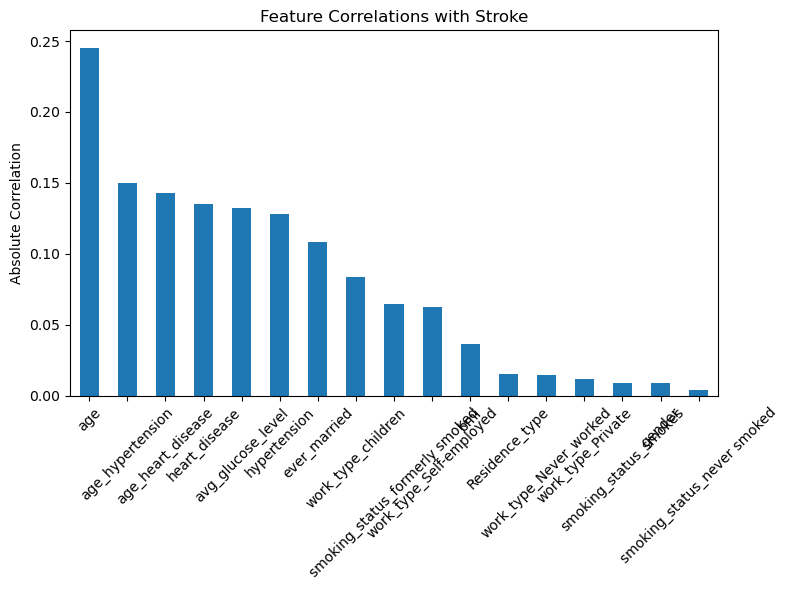

In [13]:
# Correlation with stroke
corr_matrix = encoded_sk.corr()
stroke_matrix = corr_matrix['stroke'].drop('stroke')
sorted_matrix = stroke_matrix.abs().sort_values(ascending=False)
print("Correlation with Stroke:\n", sorted_matrix)

# Plot correlations with stroke
plt.figure(figsize=(8, 6))
sorted_matrix.plot(kind='bar')
plt.title('Feature Correlations with Stroke')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("..\\visualization\\stroke_correlations.png", dpi=300, bbox_inches='tight')
print('Figure saved')
plt.show()
# Simplified to bar plot for clarity

In [14]:
print('Top 3 predictors are:\n', sorted_matrix.head(3))

Top 3 predictors are:
 age                  0.245257
age_hypertension     0.149634
age_heart_disease    0.142783
Name: stroke, dtype: float64


In [15]:
encoded_sk.to_csv('..\\data\\processed_stroke_data.csv', index=False)
print("Processed data saved with shape:", encoded_sk.shape)
# Updated to ensure all 5110 rows are saved

Processed data saved with shape: (5110, 18)


In [16]:
processed_df = pd.read_csv('..\\data\\processed_stroke_data.csv')
print(processed_df.shape)
print(processed_df.columns)
print(processed_df.info())
# Should show (5110, 18) with new features

(5110, 18)
Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'age_hypertension', 'age_heart_disease'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5110 non-null   int64  
 1   age                             5110 non-null   float64
 2   hypertension                    5110 non-null   int64  
 3   heart_disease                   5110 non-null   int64  
 4   ever_married                    5110 non-null   int64  
 5   Residence_type                  5110

In [17]:
X = processed_df.drop('stroke', axis=1)
y = processed_df['stroke']

# Stratified train-test split
x_train, x_test, y_train , y_test= train_test_split(X, y, random_state=42, train_size=0.8, stratify=y)
print('y_train shape:\n', y_train.value_counts())
print('y_test shape:\n', y_test.value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
x_train_sampled, y_train_sampled = smote.fit_resample(x_train, y_train)
print('\nAfter applying SMOTE:\n')
print('y_train shape:\n', y_train_sampled.value_counts())
print('x_train_sampled shape:', x_train_sampled.shape)
# Added stratification to ensure balanced test set

y_train shape:
 stroke
0    3889
1     199
Name: count, dtype: int64
y_test shape:
 stroke
0    972
1     50
Name: count, dtype: int64

After applying SMOTE:

y_train shape:
 stroke
0    3889
1    3889
Name: count, dtype: int64
x_train_sampled shape: (7778, 17)


In [18]:
# Define columns to scale
columns_to_scale = ['age', 'avg_glucose_level', 'bmi', 'age_hypertension', 'age_heart_disease']

# Use StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'
)

# Fit and transform training data
x_train_scaled = preprocessor.fit_transform(x_train_sampled)
x_test_scaled = preprocessor.transform(x_test)

print('x_train_scaled shape:', x_train_scaled.shape)
print('x_test_scaled shape:', x_test_scaled.shape)
# Fixed scaling to use StandardScaler and include new features

x_train_scaled shape: (7778, 17)
x_test_scaled shape: (1022, 17)


In [19]:
svc = SVC(kernel='rbf', probability=True, random_state=42)
knc = KNeighborsClassifier(n_neighbors=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced', random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=10)
# Updated SVC kernel, added class weighting

In [20]:
models = {
    'SVC': svc,
    'KNC': knc,
    'LRC': lrc,
    'RFC': rfc,
    'XGB': xgb
}

In [21]:
from sklearn.metrics import recall_score, roc_auc_score

def train_model(model, x_train_sampled, y_train_sampled, x_test, y_test):
    model.fit(x_train_sampled, y_train_sampled)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]) if hasattr(model, "predict_proba") else None
    return precision, accuracy, recall, roc_auc, y_pred

In [22]:
results = {}
for name, model in models.items():
    precision, accuracy, recall, roc_auc, y_pred = train_model(model, x_train_scaled, y_train_sampled, x_test_scaled, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc
    }
    print(f'\nFor {name}:')
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}' if roc_auc else 'ROC-AUC: N/A')

# Display results summary
results_df = pd.DataFrame(results).T
print("\nResults Summary:")
print(results_df)
# Fixed metric order, added recall and ROC-AUC


For SVC:
Confusion Matrix:
 [[858 114]
 [ 26  24]]
Accuracy: 0.8630
Precision: 0.1739
Recall: 0.4800
ROC-AUC: 0.7888

For KNC:
Confusion Matrix:
 [[839 133]
 [ 35  15]]
Accuracy: 0.8356
Precision: 0.1014
Recall: 0.3000
ROC-AUC: 0.6649

For LRC:
Confusion Matrix:
 [[816 156]
 [ 21  29]]
Accuracy: 0.8268
Precision: 0.1568
Recall: 0.5800
ROC-AUC: 0.7979

For RFC:
Confusion Matrix:
 [[926  46]
 [ 39  11]]
Accuracy: 0.9168
Precision: 0.1930
Recall: 0.2200
ROC-AUC: 0.7895

For XGB:
Confusion Matrix:
 [[886  86]
 [ 34  16]]
Accuracy: 0.8826
Precision: 0.1569
Recall: 0.3200
ROC-AUC: 0.7801

Results Summary:
     Accuracy  Precision  Recall   ROC-AUC
SVC  0.863014   0.173913    0.48  0.788755
KNC  0.835616   0.101351    0.30  0.664928
LRC  0.826810   0.156757    0.58  0.797860
RFC  0.916830   0.192982    0.22  0.789516
XGB  0.882583   0.156863    0.32  0.780123


In [23]:
# Tune XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(random_state=42, scale_pos_weight=10)
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(x_train_scaled, y_train_sampled)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(x_test_scaled)
print("Best Parameters:", grid_search.best_params_)
print("Best ROC-AUC (CV):", grid_search.best_score_)
print("\nBest Model Performance:")
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))
print(f'ROC-AUC: {roc_auc_score(y_test, best_model.predict_proba(x_test_scaled)[:, 1]):.4f}')
# Added tuning to optimize performance

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Best ROC-AUC (CV): 0.9934163672465031

Best Model Performance:
Confusion Matrix:
 [[886  86]
 [ 36  14]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       972
           1       0.14      0.28      0.19        50

    accuracy                           0.88      1022
   macro avg       0.55      0.60      0.56      1022
weighted avg       0.92      0.88      0.90      1022

ROC-AUC: 0.7891


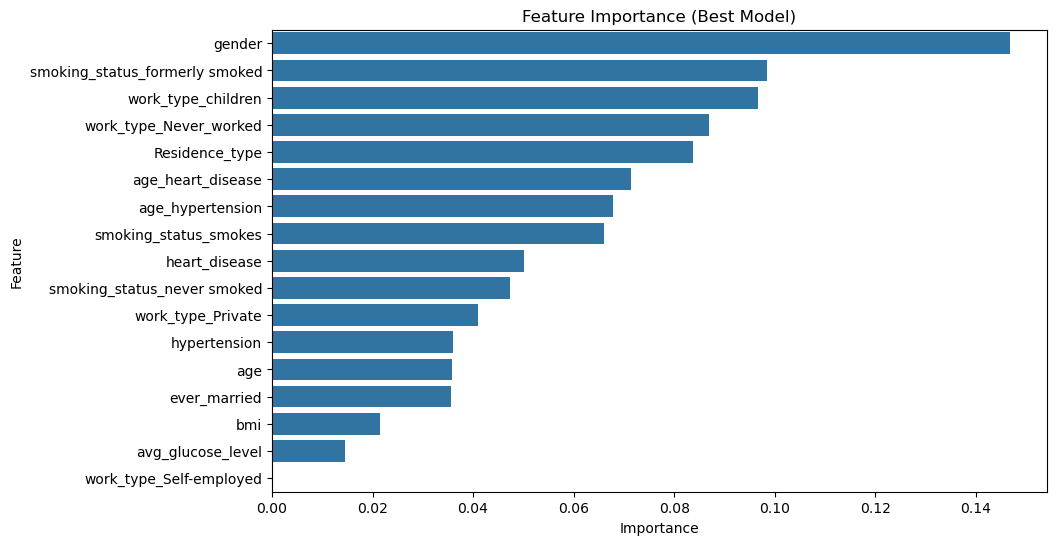

                           Feature  Importance
0                           gender    0.146831
12  smoking_status_formerly smoked    0.098543
11              work_type_children    0.096772
8           work_type_Never_worked    0.086868
5                   Residence_type    0.083827
16               age_heart_disease    0.071312
15                age_hypertension    0.067909
14           smoking_status_smokes    0.066028
3                    heart_disease    0.050052
13     smoking_status_never smoked    0.047413
9                work_type_Private    0.040948
2                     hypertension    0.035948
1                              age    0.035889
4                     ever_married    0.035554
7                              bmi    0.021558
6                avg_glucose_level    0.014549
10         work_type_Self-employed    0.000000


In [24]:
# Feature importance for best model
importances = best_model.feature_importances_
feature_names = x_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance (Best Model)')
plt.savefig('..\\visualization\\feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print(importance_df)
# Added to analyze feature contributions